# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [21]:
# import libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin

In [23]:
# load data from database
def load_data(database_filepath):
    engine = create_engine('sqlite:///'+database_filepath)
    df = pd.read_sql("SELECT * FROM DisasterResponse", engine)
    X = df['message'].values
    y = df.drop(['id','message','original','genre'],axis=1).values
    category_names = list(df.columns[4:])
    return X, y, category_names

In [3]:
X, y, category = load_data('data/DisasterResponse.db')

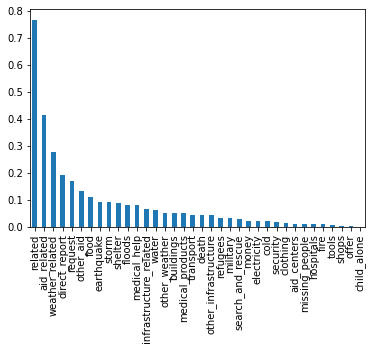

In [24]:
responses = pd.DataFrame(y, columns=category)
responses.mean().sort_values(ascending=False).plot(kind='bar');

### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [7]:
# X, y, category_names = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# train classifier
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fa148471d40>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [9]:
# predict on test data
y_pred = pipeline.predict(X_test)

In [10]:
# evaluate classification model
def evaluate_model(y_test, y_pred, category):
    clsReport = classification_report(y_test, y_pred, target_names = category, zero_division=1)
    print("Classification report:", clsReport)

evaluate_model(y_test, y_pred, category)

Classification report:                         precision    recall  f1-score   support

               related       0.81      0.97      0.88      4991
               request       0.89      0.42      0.57      1111
                 offer       1.00      0.00      0.00        33
           aid_related       0.78      0.62      0.69      2670
          medical_help       0.72      0.06      0.11       535
      medical_products       0.83      0.06      0.11       344
     search_and_rescue       0.78      0.04      0.08       159
              security       0.33      0.01      0.02       116
              military       0.69      0.04      0.08       200
           child_alone       1.00      1.00      1.00         0
                 water       0.87      0.24      0.37       418
                  food       0.88      0.41      0.56       745
               shelter       0.83      0.27      0.41       581
              clothing       0.75      0.06      0.11        98
                

### 6. Improve your model
Use grid search to find better parameters. 

In [11]:
def build_model():
    # specify parameters for grid search
    parameters = {
    'clf__estimator__bootstrap': [True],
    'clf__estimator__min_samples_leaf': [1, 2, 3],
    'clf__estimator__min_samples_split': [2, 4, 6],
    'clf__estimator__n_estimators': [20, 50, 100]
    }
    # create grid search object
    cv = GridSearchCV(estimator = pipeline, param_grid = parameters, cv = 3, n_jobs=-1, verbose=2)

    return cv

In [12]:
model = build_model()           
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 104.0min finished


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [13]:
accuracy = (y_pred == y_test).mean()
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9464830637778456
Precision: 0.7901120390574569
Recall: 0.49647287764534176


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [14]:
def findBestModel(X_train, y_train, X_test, y_test):
    algos = {
        'RandomForestClassifier': {
            'model': MultiOutputClassifier(RandomForestClassifier()),
            'params': {
                'clf__estimator__bootstrap': [True],
                'clf__estimator__min_samples_leaf': [1, 2],
                'clf__estimator__min_samples_split': [2, 4],
                'clf__estimator__n_estimators': [100, 200]
                }
        },

        'DecisionTreeClassifier' : {
            'model': MultiOutputClassifier(DecisionTreeClassifier()),
            'params': {
                'clf__estimator__min_samples_split': [2, 4],
                'clf__estimator__min_samples_leaf': [1, 2]
            }
        },

        'AdaBoostClassifier': {
            'model': MultiOutputClassifier(AdaBoostClassifier()),
            'params': {
                'clf__estimator__n_estimators': [50, 80],
                'clf__estimator__learning_rate': [0.01, 0.1, 0.5]
            }
        }
    }
    scores = []
    for algo_name, config in algos.items():
        pipeline = Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer()),
            ('clf', config['model'])
        ])
        
        gs = GridSearchCV(pipeline, config['params'], cv=3, n_jobs=-1, verbose=2, return_train_score=False)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_,
            'accuracy': (y_pred == y_test).mean(),
            'precision': precision_score(y_test, y_pred, average='weighted', zero_division=1),
            'recall': recall_score(y_test, y_pred, average='weighted', zero_division=1)
        })
    df = pd.DataFrame(scores,columns=['model', 'best_score', 'best_params', 'accuracy', 'precision', 'recall'])
    return df

In [15]:
df = findBestModel(X_train, y_train, X_test, y_test)
df

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 147.8min finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 182.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 182.3min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 38.5min finished


,model,best_score,best_params,accuracy,precision,recall
0,RandomForestClassifier,0.251907,"{'clf__estimator__bootstrap': True, 'clf__esti...",0.946763,0.799444,0.500803
1,DecisionTreeClassifier,0.167430,"{'clf__estimator__min_samples_leaf': 2, 'clf__...",0.935341,0.626962,0.562491
2,AdaBoostClassifier,0.279371,"{'clf__estimator__learning_rate': 0.5, 'clf__e...",0.950124,0.749455,0.577621


In [18]:
clf_learning_rate = df.loc[2, 'best_params']['clf__estimator__learning_rate']
clf_n_estimators = df.loc[2, 'best_params']['clf__estimator__n_estimators']

pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(AdaBoostClassifier(learning_rate=clf_learning_rate, n_estimators=clf_n_estimators)))
])
      
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fa148471d40>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(learning_rate=0.5,
                                                                    n_estimators=200)))])

### 9. Export your model as a pickle file

In [20]:
def save_model(model, classifier_filepath):
    pickle.dump(model, open(classifier_filepath, 'wb'))

save_model(pipeline, 'models/classifier.pkl')

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [ ]:
def main():
    if len(sys.argv) == 3:

        database_filepath, classifier_filepath = sys.argv[1:]

        print('Loading data...\n    DATABASE: {}'.format(database_filepath))
        X, y, category = load_data(database_filepath)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

        print('Training model...\n')    
        model = build_model()      
        model.fit(X_train, y_train)

        print('Predicting on test data...\n') 
        y_pred = model.predict(X_test)

        print('Evaluating model...\n')
        evaluate_model(y_test, y_pred, category)
        
        print('Saving model...\n    MODEL: {}'.format(classifier_filepath))
        save_model(model, classifier_filepath)
        
        print('Trained model saved!')
    
    else:
        print('Please provide the filepath of the disaster response database '\
              'as the first argument and the filepath of the pickle file to '\
              'save the model to as the second argument. \n\nExample: python '\
              'models/train_classifier.py data/DisasterResponse.db models/classifier.pkl')

if __name__ == '__main__':
    main()